In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#데이터 불러오기
app_store_df = pd.read_csv("./app_store_modified_2.csv")        #GH_Data_1_2_pre1에서 가공한 자료 불러오기
app_store_df = app_store_df.drop(['Unnamed: 0'], axis=1)
app_store_df = app_store_df[app_store_df.Installs>=1000].reset_index(drop=True)     #Install 1000이상 어플로 추천 대상 제한
app_store_df = app_store_df[app_store_df['Category'].str.contains("GAME|EDUCATION")].reset_index(drop=True)     #GAME 또는 EDUCATION 키워드가 있는 카테고리로 추천 대상 제한



In [2]:
#앱 랜덤 조합 만들기
import time
start = time.time()
import random

#랜덤 조합 생성 함수 
def make_random_combination():
    out = pd.DataFrame({'NPriceD': [], 'NSizeM': []})
    random_pool = list(range(len(app_store_df)))
    while(True):
        if(out.NPriceD.sum()<=20 and out.NSizeM.sum()<=500):        #가격합 20$이하 용량합 500M이하 조합 생성
            index = random_pool.pop(random.randint(0,len(random_pool)-1))
            out = out.append(app_store_df.loc[index],ignore_index=True)
            if(out.NPriceD.sum()>=19 and out.NPriceD.sum()<=20) or (out.NSizeM.sum()<=500 and out.NSizeM.sum()>=450):
                break
        else:
            out.drop(out.tail(1).index,inplace=True)
    print(out.NPriceD.sum(), out.NSizeM.sum())      ##가격합과 용량합 로그 
    if(out.NPriceD.sum() > 20):     #용량합이 500M에 가까운 경우 가격합이 20$를 넘는 경우 발생 - 해당 경우는 마지막 item 제거
        out.drop(out.tail(1).index,inplace=True)
    return out

#랜덤조합 1000번 시행하여 리스트에 저장
makelist = []
for i in range(1000):
    print (i)               #오랜 시간이 걸리므로 현재상황 로그 
    makelist.append(make_random_combination())
    
print("time :", time.time() - start)

910000000000004 244.9
26
19.450000000000003 251.0
27
19.43 216.60000000000002
28
19.93 233.2
29
19.950000000000003 79.1
30
19.449999999999996 211.0
31
19.91 507.3
32
19.92 370.3
33
19.959999999999997 220.0
34
19.91 403.0
35
19.95 171.8
36
19.330000000000002 257.8
37
19.130000000000003 216.2
38
19.44 183.9
39
19.94 215.0
40
19.42 310.6
41
19.450000000000003 252.0
42
19.94 206.1
43
19.459999999999997 111.0
44
19.93 365.0
45
19.940000000000005 154.9
46
19.93 211.5
47
19.9 381.0
48
19.950000000000003 206.1
49
19.450000000000003 78.39999999999999
50
19.93 203.6
51
19.42 320.3
52
19.91 381.5
53
19.92 273.7
54
19.94 173.6
55
19.939999999999998 216.0
56
19.42 349.1
57
19.939999999999998 208.3
58
19.98 246.9
59
19.94 331.0
60
19.950000000000003 241.4
61
19.959999999999997 127.5
62
19.93 195.9
63
19.92 245.29999999999998
64
19.429999999999996 318.1
65
19.43 206.109
66
19.93 322.4
67
19.92 244.5
68
19.929999999999996 196.7
69
19.959999999999997 189.0
70
19.17 334.9
71
19.929999999999996 228.9
72


In [3]:
#생성된 리스트 내의 데이터프레임 내 앱 중 카테고리가 추천 기반 어플과 정확히 일치하는 항목은 Rating에 0.5 추가
for i in list(range(len(makelist))):
    for j in list(range(len(makelist[i]))):
        if makelist[i].Category[j] == 'GAME_ACTION' or makelist[i].Category[j] == 'GAME_ADVENTURE' or makelist[i].Category[j] == 'GAME_EDUCATIONAL':
            makelist[i].Rating[j] += 0.5

In [4]:
#평가 가중합을 구하여 리스트에 저장
def cal_wei_rat(lis):
    cal_wei_rat = []
    for i in list(range(len(lis))):
        cal_wei_rat.append(lis[i].NPriceD @ lis[i].Rating)    #Rating과 가격의 Sumproduct로 평가 가중합 산출
    return cal_wei_rat

wei_rat = cal_wei_rat(makelist)

In [5]:
#위험도 요인 중 Rating과 Reviews 요인 반영값 산출 - 답안 내 표 참조
def RR(df):
    if df.Rating >= 4.5 and df.Reviews >= 1000:
        return 0
    elif df.Rating < 4.5 and df.Reviews < 1000:
        return 1
    else: 
        return 0.6

#std_rating과 RR함수를 이용해 위험도값 산출하는 함수
def cal_cred(lis):
    cal_cred = []
    for i in list(range(len(lis))):
        ind_risk = 0
        for j in list(range(len(lis[i]))):
            ind_risk += (lis[i].stds_rating[j]+ RR(lis[i].loc[j])) * lis[i].NPriceD[j]
        ind_risk = ind_risk/lis[i].NPriceD.sum()
        cal_cred.append(ind_risk)
    return cal_cred

#실제 위험도값 산출
cred = cal_cred(makelist)


In [6]:
#추천 기반 어플 조합의 위험도 산출

#추천 기반 어플 데이터프레임에 저장
recommendation_base = app_store_df[app_store_df['App Name'] == 'Five Nights at Freddy\'s 4']
recommendation_base = recommendation_base.append(app_store_df[app_store_df['App Name'] == 'PAW Patrol Pups to the Rescue'])
recommendation_base = recommendation_base.append(app_store_df[app_store_df['App Name'] == 'My Town : Farm' ])
recommendation_base = recommendation_base.reset_index(drop=True)

#추천 기반 어플 조합의 위험도 산출 함수
def cal_rec_cred(df):
    ind_risk = 0
    for i in list(range(len(df))):
        ind_risk += (df.stds_rating[i]+ RR(df.loc[i])) * df.NPriceD[i]
    ind_risk = ind_risk/df.NPriceD.sum()
    return ind_risk
rec_cred = cal_rec_cred(recommendation_base)

#추천 기반 어플 조합의 위험도 산출 로그
rec_cred

1.9184274599198592

Text(0.5, 1.0, 'Risk & Weighted Rating')

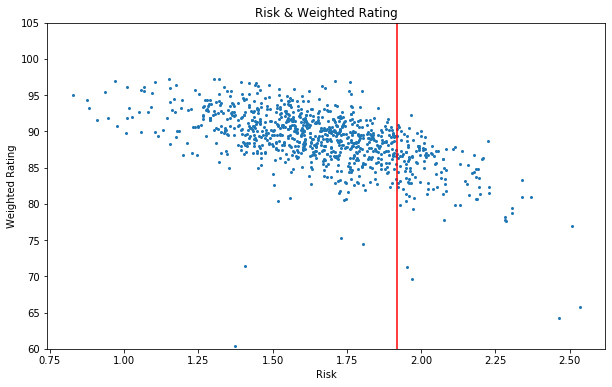

In [7]:
#산점도 작성
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.ylim(60,105)
plt.plot(cred,wei_rat,'o', markersize=2)
plt.plot([rec_cred,rec_cred],[60,105],color='r') #추천 기반 어플 조합의 위험도 1.9184 붉은 선 표시
plt.xlabel('Risk')
plt.ylabel('Weighted Rating')
plt.title('Risk & Weighted Rating')

In [8]:
#추천 기반 어플의 위험도보다 작은 위험도를 갖고 있는 조합만 리스트에 저장
recom_list = list(filter(lambda x: cal_rec_cred(x)<=rec_cred,makelist))

#해당 리스트 길이 로그
len(recom_list)

802

In [9]:
#최종 추천 조합 선택
recom_list_2 = cal_wei_rat(recom_list)
print(max(recom_list_2))    #최종 추천 조합의 평가 가중합 로그
print(cal_rec_cred(recom_list[recom_list_2.index(max(recom_list_2))]))  #최종 추천 조합의 위험도 로그
recom_list[recom_list_2.index(max(recom_list_2))]   #최종 추천 조합 출력

97.28723946175
1.3212368665748595


,NPriceD,NSizeM,App Name,Category,Installs,Price,Rating,Reviews,Size,package_name,stds_rating
0,3.99,25.0,Teeny Titans - Teen Titans Go!,GAME_STRATEGY,100000.0,$3.99,4.619890,21991.0,25M,com.turner.ttgfigures,1.229126
1,0.99,5.5,Piano Master National Anthems,GAME_MUSIC,5000.0,$0.99,3.837209,172.0,5.5M,it.b77.pianomasterworld,1.513008
2,7.99,24.0,Titan Quest,GAME_ACTION,50000.0,$7.99,5.014472,13163.0,24M,com.dotemu.titanquest,1.354670
3,2.99,9.8,ISS Detector Pro,EDUCATION,10000.0,$2.99,4.773923,2623.0,9.8M,com.runar.issdetector.pro,1.049236
4,3.99,46.0,Thinkrolls 2 - Logic Puzzles,GAME_EDUCATIONAL,10000.0,$3.99,5.191824,318.0,46M,com.avokiddo.games.thinkrolls2,0.654525


In [ ]:
#어느정도에서 Rating이 높고 낮은지를 판단하기 위한 히스토그램 
plt.figure(figsize = (10,5))
plt.subplot(2,2,1)
plt.hist(app_store_df.Rating)
plt.subplot(2,2,2)
plt.hist(app_store_df.Rating[app_store_df.Rating<=4])
plt.subplot(2,2,3)
plt.hist(app_store_df.Rating[app_store_df.Rating>=4])
plt.subplot(2,2,4)
plt.hist(app_store_df.Rating[app_store_df.Rating>=3])


In [ ]:
#어느정도에서 Reviews가 높고 낮은지를 판단하기 위한 히스토그램 
plt.figure(figsize = (10,5))
plt.subplot(2,2,1)
plt.hist(app_store_df.Reviews)
plt.subplot(2,2,2)
plt.hist(app_store_df.Reviews[app_store_df.Reviews<=100000])
plt.subplot(2,2,3)
plt.hist(app_store_df.Reviews[app_store_df.Reviews<=10000])
plt.subplot(2,2,4)
plt.hist(app_store_df.Reviews[app_store_df.Reviews<=5000])
len(app_store_df.Reviews[app_store_df.Reviews>=1000])